## Infinite Impulse Response (IIR) Filters (Remixed)

In [18]:
def sample_poles(filter_order):
    """
    Systems represented by stable right-sided sequences have all poles located within the unit circle, which suggests all eigenvalues of the system have magnitude less than one and thus state variables decay over time.
    """
    centerX = centerY = 0
    R = 1
    z = [0] * filter_order
    p = []
    for _ in range(filter_order // 2):
        r = R * np.sqrt(np.random.rand())
        theta = np.random.rand() * 2 * np.pi
        x = centerX + r * np.cos(theta)
        y = centerY + r * np.sin(theta)
        t = x + y * 1j

        p.append(t)
        p.append(t.conjugate())

    if filter_order%2 == 1:
        p.append(np.random.rand())
    return z, p

def create_gaussian_signal(seq_len, b, a):
    """
    Filter gaussian noise throught the IIR filter designed via Pole-sampling
    """
    xn = np.random.normal(0, 1, size=seq_len)
    x = np.tanh(signal.lfilter(b, a, xn))

    return xn, x

# Create input and output of shape (batch_size x seq_len x input_dims) 
def create_dataset(batch_size, seq_len, b, a):

    X = []
    Y = []
    for _ in range(batch_size):
        xn, x = create_gaussian_signal(seq_len, b, a)
        X.append(xn)
        Y.append(x)
            
    X = np.array(X)
    X = np.swapaxes(X, 0, 1)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.swapaxes(Y, 0, 1)
    Y = np.expand_dims(Y, axis=2)

    return X, Y

In [19]:
import numpy as np
import scipy.signal as signal

# Set Parameters
filter_order = N = 3
hidden_size = 3

seq_len = 150
wash_out = 50
batch_size = 100
split_ratio = 0.8

# Generate Data
z, p = sample_poles(filter_order)
b, a = signal.zpk2tf(z, p, 1)
X, Y = create_dataset(batch_size, seq_len, b, a)

split_index = int(split_ratio*batch_size)
train_X, train_Y = X[:,:split_index,:], Y[:,:split_index,:]
test_X, test_Y = X[:,split_index:,:], Y[:,split_index:,:]

## Visualize the Response
### Impulse Response

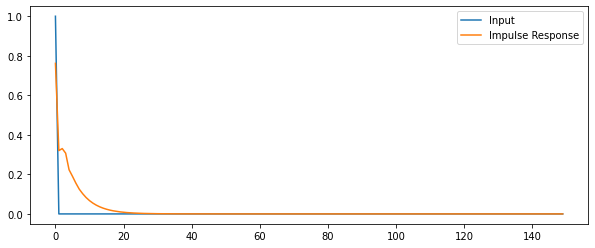

In [20]:
import matplotlib.pyplot as plt

input = signal.unit_impulse(seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(input, label="Input")
ax.plot(output, label="Impulse Response")
plt.legend()
plt.show()

### Gaussian Noise

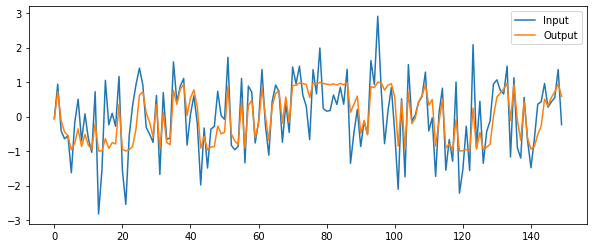

In [21]:
input = np.random.normal(0, 1, size=seq_len)
output = np.tanh(signal.lfilter(b, a, input))

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(input, label="Input")
ax.plot(output, label="Output")
plt.legend()
plt.show()

## Define Recurrent Neural Network Model


In [22]:
import torch
from torch import nn

class RNNLayer(nn.Module):
    """Linear RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
                if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = self.i2h(input) + self.h2h(hidden)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = torch.tanh(self.fc(rnn_output))
        return out, rnn_output

In [23]:
# Instantiate Model
net = RNNNet(1, N, 1)

# Shifted diagonal matrix and IIR filter coefficients
a_copy = -a
a_copy[0] = 1
h2h = torch.diag(torch.ones(N-1), diagonal=-1)
h2h[0,:] = torch.from_numpy(a_copy[1:])
net.rnn.h2h.weight = nn.Parameter(h2h)

# Vector with a "1" for input x
i2h = torch.zeros((N,1))
i2h[0,0] = torch.tensor(1.0)
net.rnn.i2h.weight = nn.Parameter(i2h)

# Weight for linear output layer to select h[0]
fc = torch.zeros((1,N))
fc[0][0] = torch.tensor(1.0)
net.fc.weight = nn.Parameter(fc)

# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_output = net(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_optimal = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_optimal)

1.3158802e-15


In [24]:
import cmath
import matplotlib.pyplot as plt

def extract_eigen_values(M):
    eW = np.linalg.eigvals(M)
    rea = [n.real for n in eW]
    imag = [n.imag for n in eW]
    return rea, imag

def polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt):
    fig = plt.figure(figsize=(12,12))

    theta, r = [], []
    for i,j in zip(real_poles, imag_poles):
        r_c, theta_c = cmath.polar(complex(i, j))
        r.append(r_c)
        theta.append(theta_c)

    r_bptt, theta_bptt = [], []
    for i,j in zip(realW_bptt, imagW_bptt):
        r_c, theta_c = cmath.polar(complex(i, j))
        r_bptt.append(r_c)
        theta_bptt.append(theta_c)

    ax = fig.add_subplot(121, projection='polar')
    ax.scatter(theta, r, color='blue', marker='x', label='Poles')
    ax.scatter(theta_bptt, r_bptt, color='red', marker='.', label='Eigenvalues')
    ax.set_rmax(1)
    ax.set_rticks([0.25, 0.5, 0.75, 1])    # Less radial ticks
    ax.set_rlabel_position(-22.5)          # Move radial labels away from plotted line
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1, -0.05), loc="center right", frameon=False)
    plt.show()  

## Train the RNN

In [25]:
net_trained = RNNNet(1, hidden_size, 1)

optimizer = torch.optim.Adam(net_trained.parameters(), lr=0.01)

loss_train = []

epochs = 3000
for epoch in range(epochs):
    # Zero the gradient buffer
    optimizer.zero_grad()
    
    # Forward pass
    train_inp = torch.from_numpy(train_X).type(torch.float)
    train_out = torch.from_numpy(train_Y).type(torch.float)
    pred, _ = net_trained(train_inp)

    # Measure the loss
    loss = criterion(pred[:,wash_out:,:], train_out[:,wash_out:,:])
    loss_train.append(loss.data.item())

    # Print the loss
    if epoch%50==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 0.2862662076950073
50 0.009789030998945236
100 0.00013463388313539326
150 4.0498758608009666e-05
200 2.271726589242462e-05
250 1.6596140994806774e-05
300 1.3889110960008111e-05
350 1.1860724953294266e-05
400 1.0041188943432644e-05
450 8.398870704695582e-06
500 6.9412908487720415e-06
550 5.669681286235573e-06
600 4.577906111080665e-06
650 3.6544624890666455e-06
700 2.8844206099165604e-06
750 2.251022806376568e-06
800 1.736901253934775e-06
850 1.3249808716864209e-06
900 9.991681508836336e-07
950 7.447379175573587e-07
1000 5.485613883138285e-07
1050 3.9923784811435326e-07
1100 2.870268644983298e-07
1150 2.0380169019063032e-07
1200 1.4288349348134943e-07
1250 9.888454144402203e-08
1300 6.75334703714725e-08
1350 4.5503874446239934e-08
1400 3.0239956316790995e-08
1450 1.981512021131948e-08
1500 1.2797761073102265e-08
1550 8.144545482480225e-09
1600 5.105323275245155e-09
1650 3.150934624329693e-09
1700 1.9143062690574197e-09
1750 1.144401018393637e-09
1800 6.729087842494152e-10
1850 3.88953

In [26]:
def plot_loss_history(loss_train, loss_test, loss_optimal):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='red', label ="BPTT Train")
    ax.loglog(loss_test*np.ones(epochs), color='orange', label ="BPTT Test")
    ax.loglog(loss_optimal*np.ones(epochs), color='blue', label ="Optimal")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.legend()
    plt.show()

5.085804e-15


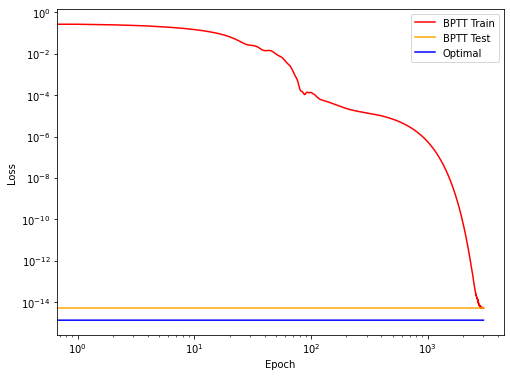

In [27]:
# Predict
test_inp = torch.from_numpy(test_X).type(torch.float)
test_out = torch.from_numpy(test_Y).type(torch.float)
pred, rnn_activity = net_trained(test_inp)

# Compute Loss
criterion = nn.MSELoss()
loss_test = criterion(pred[wash_out:,:,:], test_out[wash_out:,:,:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test, loss_optimal)

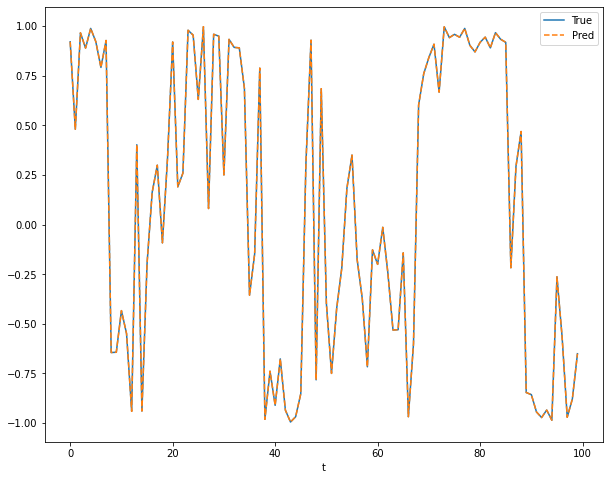

In [28]:
def plot_time_series(true, pred):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot(true, label="True", linestyle='solid')
    ax.plot(pred, label="Pred", linestyle='dashed')
    ax.set_xlabel("t")
    plt.legend(loc=1)
    plt.show()

index_to_plot = 0
plot_time_series(test_out[wash_out:,index_to_plot,0].detach().numpy(), pred[wash_out:,index_to_plot,0].detach().numpy())

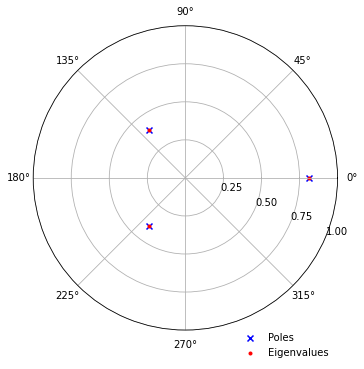

In [37]:
real_poles, imag_poles = [x.real for x in p], [x.imag for x in p]
realW_bptt, imagW_bptt = extract_eigen_values(net_trained.rnn.h2h.weight.detach().numpy())
polar_plot(real_poles, imag_poles, realW_bptt, imagW_bptt)

## Comparison of target time-series FT and hidden activity FT

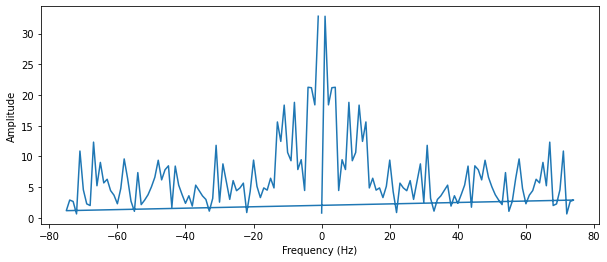

In [30]:
from scipy import fftpack

fft = fftpack.fft(output)

amplitude = abs(fft)
power = amplitude**2
angle = np.angle(fft)

peak_amplitude_index = np.argmax(abs(fft))

sample_freq = fftpack.fftfreq(len(output), d=1/seq_len)
peak_amplitude_freq = sample_freq[peak_amplitude_index]

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(sample_freq, abs(fft))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.show()

In [31]:
print(peak_amplitude_index)
print(peak_amplitude_freq)

1
1.0


In [32]:
print(realW_bptt)
print(imagW_bptt)

[0.81106746, -0.23952843, -0.23952843]
[0.0, 0.31297386, -0.31297386]


In [35]:
print(imagW_bptt[0]/(2*np.pi))

0.0
